In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts.models import NBEATSModel
from darts import TimeSeries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
def predict_exo(train_exo, val_len, s, X_val=None, plot=True):
    result = pd.DataFrame()
    for col in train_exo.columns:
        model = ExponentialSmoothing(train_exo[col], trend='add', seasonal='add', seasonal_periods=s)
        forecast = model.fit().forecast(steps=val_len)
        result[col] = forecast
        if plot:
            plt.figure()
            sns.lineplot(data=train_exo[col], label=col)
            sns.lineplot(data=forecast, label='Forecast')
            sns.lineplot(data=X_val[col], label='gt')
    return result

In [3]:
df_origal = pd.read_csv('./data/preprocessed_football.csv')
df_origal = df_origal[df_origal['Comp'] == 0]

In [4]:
TEAM_ORDER = {
    0: [(0, 0, 9), 12],
    1: [(6, 6, 8), 12],
    2: [(8, 0, 4), 4],
    3: [(0, 6, 9), 12],
    4: [(1, 4, 9), 4],
    5: [(8, 0, 1), 4],
    6: [(3, 4, 9), 12],
    7: [(9, 0, 5), 2]
}

TEAM_NAME = {
    0: 'Atlético Madrid',
    1: 'Barcelona',
    2: 'Getafe',
    3: 'Real Madrid',
    4: 'Real Sociedad',
    5: 'Sevilla',
    6: 'Valencia',
    7: 'Villarreal'
}

In [5]:
def predict_team_number(n: int, year_interested=-1, plot=True):
    """
    if year_interested equals -1, then 4 validation years are returned;
    otherwise, only the specified index is returned.
    """
    if not (0 <= n <= 7):
        print('No such team number')
        exit(-1)
    if not (-1 <= year_interested < 4):
        print('Wrong year_interested value. Should be in range [0, 4) or -1.')
        exit(-1)
        
    # print(f'Team: {TEAM_NAME[n]}')

    # data preprocessing
    df_orig = df_origal[df_origal['Squad'] == n]
    df = df_orig.drop(['Squad', 'Comp', 'Attendance', 'Goalkeeper', 'Top Team Scorers', 'Top Team Goals'], axis=1)

    df = df.iloc[::-1, :]
    df = df.iloc[:-1, :]
    df.drop(['Season'], axis=1, inplace=True)
    scale_w = np.full((len(df), 1), fill_value=3)
    scale_w[:7] = 2
    df['Scale_w'] = scale_w

    y = df['Pts']
    X = df.drop(['Pts'], axis=1)
    y.reset_index(drop=True, inplace=True)
    X.reset_index(drop=True, inplace=True)
    X_train, X_val, y_train, y_val = X.iloc[:-4, :], X.iloc[-4:, :], y.iloc[:-4], y.iloc[-4:]

    # training
    y1 = df['W']
    y2 = df['D']
    X = df.drop(['Pts', 'MP', 'Scale_w'], axis=1)
    X1 = X.drop(['W'], axis=1)
    X2 = X.drop(['D'], axis=1)
    y1.reset_index(drop=True, inplace=True)
    y2.reset_index(drop=True, inplace=True)
    X1.reset_index(drop=True, inplace=True)
    X2.reset_index(drop=True, inplace=True)
    X1_train, X1_val, X2_train, X2_val, y1_train, y1_val, y2_train, y2_val = X1.iloc[:-4, :], X1.iloc[-4:, :], X2.iloc[:-4, :], X2.iloc[-4:, :], y1.iloc[:-4], y1.iloc[-4:], y2.iloc[:-4], y2.iloc[-4:]

    model_w = SARIMAX(y1_train, X1_train, order=TEAM_ORDER[n][0], seasonal_order=(0, 0, 0, TEAM_ORDER[n][1]))
    model_w.initialize_approximate_diffuse()
    model_w = model_w.fit(disp=False)
    
    model_d = SARIMAX(y2_train, X2_train, order=TEAM_ORDER[n][0], seasonal_order=(0, 0, 0, TEAM_ORDER[n][1]))
    model_d.initialize_approximate_diffuse()
    model_d = model_d.fit(disp=False)
    
    
    X1_val_pred = predict_exo(X1_train, len(y1_val), TEAM_ORDER[n][1], X1_val, plot=False)
    X2_val_pred = predict_exo(X2_train, len(y2_val), TEAM_ORDER[n][1], X2_val, plot=False)
    
    res_w = model_w.predict(start=len(y1_train), end=len(y1_train)+len(y1_val)-1, exog=X1_val_pred)
    res_d = model_d.predict(start=len(y2_train), end=len(y2_train)+len(y2_val)-1, exog=X2_val_pred)

    final_true = y1_val*3 + y2_val
    final_pred = pd.DataFrame()
    final_pred['pts'] = res_w * 3 + res_d

    if plot:
        rmse = mean_squared_error(y1_val*3 + y2_val, final_pred['pts']) ** 0.5
        final_pred.set_index(y1_val.index)
        plt.figure()
        sns.lineplot(data=y_train, label='Train')
        sns.lineplot(data=y1_val*3 + y2_val, label='Validation')
        sns.lineplot(data=final_pred['pts'], label='Prediction').set(title=f'{TEAM_NAME[n]}. RMSE: {round(rmse, 3)}')
        # plt.savefig('results.png')
        plt.show()
    
    if year_interested == -1:
        return final_pred['pts'].values, final_true.values
    return final_pred['pts'][0], final_true[0]
    

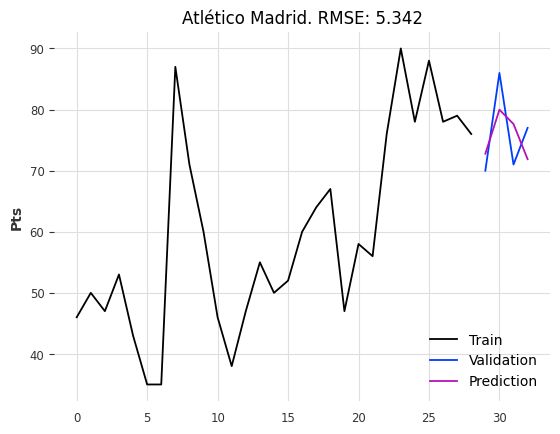

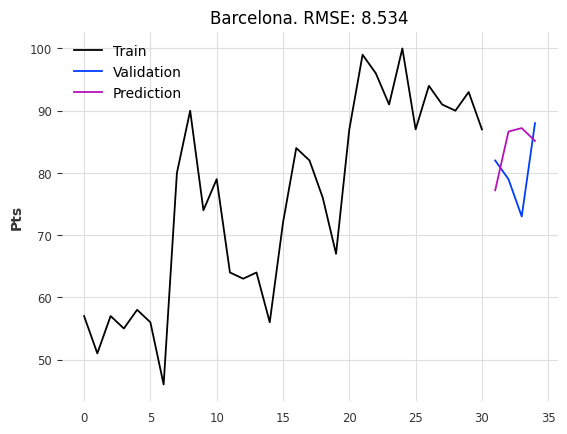

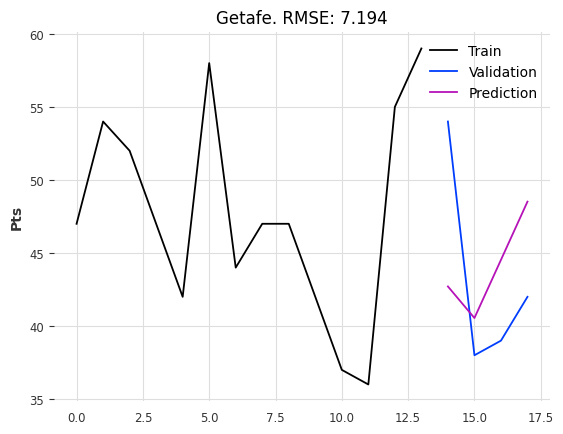

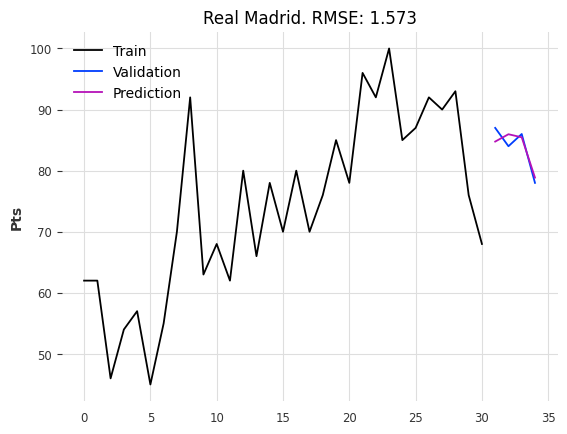

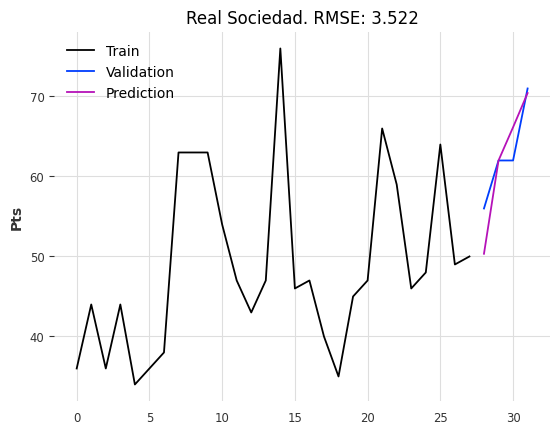

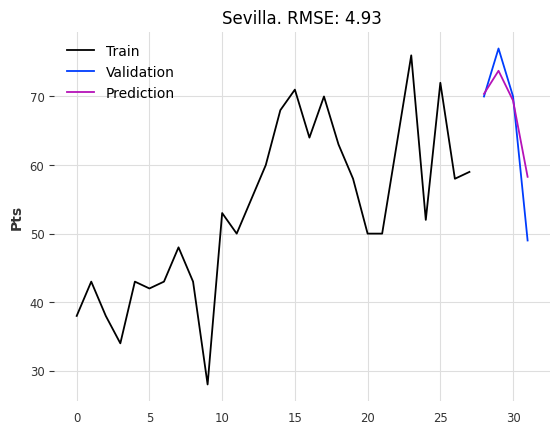

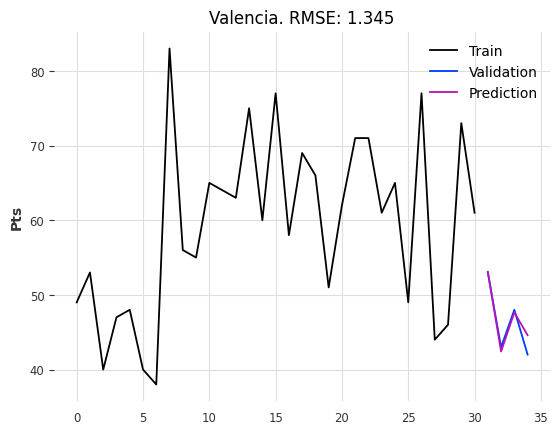

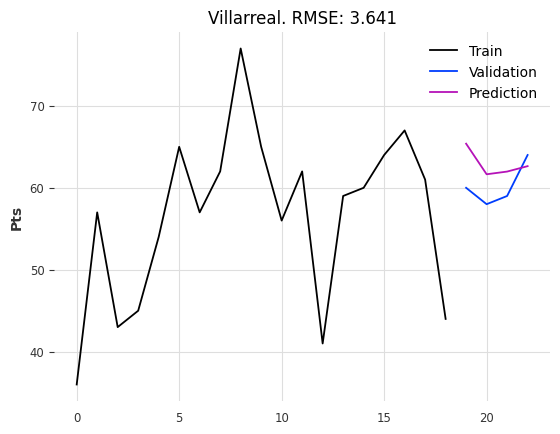

In [6]:
team_results_pred, team_results_true = [], []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(8):
        pred, true = predict_team_number(i, plot=True)
        team_results_pred.append(pred)
        team_results_true.append(true)

In [7]:
def form_leaderbord(team_results):
    team_results = np.array(team_results)
    leader_board = []
    for year in range(team_results.shape[1]):
        sorted_teams = np.argsort(team_results[:, year])[::-1]
        leader_board.append(sorted_teams)
    return leader_board

In [8]:
from pprint import pprint

pprint(list(zip(form_leaderbord(team_results_pred), form_leaderbord(team_results_true))))

[(array([3, 1, 0, 5, 7, 6, 4, 2]), array([3, 1, 5, 0, 7, 4, 2, 6])),
 (array([1, 3, 0, 5, 4, 7, 6, 2]), array([0, 3, 1, 5, 4, 7, 6, 2])),
 (array([1, 3, 0, 5, 4, 7, 6, 2]), array([3, 1, 0, 5, 4, 7, 6, 2])),
 (array([1, 3, 0, 4, 7, 5, 2, 6]), array([1, 3, 0, 4, 7, 5, 6, 2]))]


In [9]:
from scipy.stats import spearmanr

spearman_coeffs = []
matrix = list(zip(form_leaderbord(team_results_pred), form_leaderbord(team_results_true)))
for predicted, true in matrix:
    rho, _ = spearmanr(predicted, true)
    spearman_coeffs.append(rho)

print(spearman_coeffs)
print(f"Mean Spearman's Rho over years: {np.mean(spearman_coeffs)}")

[0.11904761904761905, 0.9761904761904763, 0.9047619047619048, 0.6190476190476191]
Mean Spearman's Rho over years: 0.6547619047619048
